<a href="https://colab.research.google.com/github/shinobu357/TugasMLRaisya/blob/main/UAS/Chapter_3_Computer_Vision_Raisya_Athaya_Kamilah_101032380253.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 3 - Vision Transformer

Unit ini memperkenalkan Vision Transformers, yang merupakan adaptasi dari arsitektur Transformer yang sukses dalam pemrosesan bahasa alami, untuk tugas-tugas computer vision. Vision Transformers menggunakan mekanisme perhatian (attention mechanism) untuk memproses citra, memungkinkan model untuk fokus pada bagian-bagian penting dari input. Pendekatan ini telah menunjukkan kinerja yang kompetitif dengan CNN dalam berbagai tugas computer vision.

# Swin Transformer

Swin Transformer adalah model vision transformer yang menggunakan teknik pembagian hierarkis untuk citra. Dengan membagi citra menjadi patch- patch kecil dan menggunakan sliding windows, Swin Transformer lebih efisien dalam komputasi dan dapat menangani citra beresolusi tinggi. Ini memungkinkan Swin Transformer mencapai performa yang lebih baik pada berbagai tugas pengenalan gambar dibandingkan model transformer sebelumnya

In [ ]:
import torch
import torch.nn as nn
from torch.nn.init import trunc_normal_

# Definisi kelas SwinTransformer yang menginherit nn.Module dari PyTorch
class SwinTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,  # Ukuran gambar input
        patch_size=4,  # Ukuran patch (sub-gambar) yang akan dibagi
        in_chans=3,    # Jumlah saluran input (biasanya 3 untuk RGB)
        num_classes=1000,  # Jumlah kelas output (untuk klasifikasi)
        embed_dim=96,     # Dimensi embedding untuk setiap patch
        depths=[2, 2, 6, 2],  # Jumlah lapisan transformer di setiap level
        num_heads=[3, 6, 12, 24],  # Jumlah kepala pada multi-head attention di setiap level
        window_size=7,    # Ukuran jendela lokal untuk attention
        mlp_ratio=4.0,    # Rasio dimensi MLP (feed-forward network)
        qkv_bias=True,    # Apakah menggunakan bias untuk query, key, dan value
        qk_scale=None,    # Skala untuk query dan key
        drop_rate=0.0,    # Dropout rate
        attn_drop_rate=0.0,  # Dropout rate untuk attention
        drop_path_rate=0.1,  # Drop path rate untuk stochastic depth
        norm_layer=nn.LayerNorm,  # Layer normalisasi yang digunakan
        ape=False,        # Apakah menggunakan embedding posisi absolut
        patch_norm=True,  # Apakah menggunakan normalisasi pada patch
        use_checkpoint=False,  # Apakah menggunakan checkpoint untuk menghemat memori
        fused_window_process=False,  # Apakah menggunakan fused window untuk efisiensi
        **kwargs,
    ):
        super().__init__()

        # Inisialisasi parameter model
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))  # Dimensi fitur pada layer terakhir
        self.mlp_ratio = mlp_ratio

        # Membagi gambar menjadi patch-patch non-overlapping
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )
        num_patches = self.patch_embed.num_patches  # Jumlah patch yang dihasilkan
        patches_resolution = self.patch_embed.patches_resolution  # Resolusi patch
        self.patches_resolution = patches_resolution

        # Posisi embedding absolut (jika diaktifkan)
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))  # Posisi absolut
            trunc_normal_(self.absolute_pos_embed, std=0.02)  # Inisialisasi posisi absolut

        self.pos_drop = nn.Dropout(p=drop_rate)  # Dropout untuk embedding posisi

        # Stochastic depth (drop path)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))
        ]  # Menghitung nilai drop path untuk setiap layer

        # Membuat lapisan transformer
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),  # Dimensi untuk layer ini
                input_resolution=(
                    patches_resolution[0] // (2**i_layer),
                    patches_resolution[1] // (2**i_layer),
                ),  # Resolusi input untuk layer ini
                depth=depths[i_layer],  # Jumlah blok transformer untuk layer ini
                num_heads=num_heads[i_layer],  # Jumlah kepala attention untuk layer ini
                window_size=window_size,  # Ukuran jendela untuk attention
                mlp_ratio=self.mlp_ratio,  # Rasio dimensi MLP
                qkv_bias=qkv_bias,  # Apakah menggunakan bias untuk QKV
                qk_scale=qk_scale,  # Skala untuk QK
                drop=drop_rate,  # Dropout rate
                attn_drop=attn_drop_rate,  # Dropout rate untuk attention
                drop_path=dpr[sum(depths[:i_layer]): sum(depths[: i_layer + 1])],  # Drop path untuk layer ini
                norm_layer=norm_layer,  # Layer normalisasi yang digunakan
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,  # Downsampling untuk layer selanjutnya
                use_checkpoint=use_checkpoint,  # Apakah menggunakan checkpoint
                fused_window_process=fused_window_process,  # Penggunaan fused window
            )
            self.layers.append(layer)

        # Normalisasi output dan lapisan klasifikasi
        self.norm = norm_layer(self.num_features)  # Normalisasi pada fitur akhir
        self.avgpool = nn.AdaptiveAvgPool1d(1)  # Pooling rata-rata
        self.head = (
            nn.Linear(self.num_features, num_classes)  # Layer klasifikasi untuk output akhir
            if num_classes > 0
            else nn.Identity()
        )

        self.apply(self._init_weights)  # Inisialisasi bobot

    # Fungsi untuk inisialisasi bobot model
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)  # Inisialisasi bobot dengan distribusi normal
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Inisialisasi bias menjadi 0
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)  # Inisialisasi bias LayerNorm
            nn.init.constant_(m.weight, 1.0)  # Inisialisasi bobot LayerNorm

    @torch.jit.ignore
    def no_weight_decay(self):
        # Menentukan parameter mana yang tidak akan dikenakan pembaruan bobot (misalnya, pos_embed)
        return {"absolute_pos_embed"}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        # Menentukan kata kunci untuk parameter tanpa pembaruan bobot
        return {"relative_position_bias_table"}

    # Fungsi untuk mengekstrak fitur dari input gambar
    def forward_features(self, x):
        x = self.patch_embed(x)  # Memecah gambar menjadi patch
        if self.ape:
            x = x + self.absolute_pos_embed  # Menambahkan posisi absolut (jika diaktifkan)
        x = self.pos_drop(x)  # Dropout pada posisi embedding

        # Melalui setiap layer transformer
        for layer in self.layers:
            x = layer(x)

        # Normalisasi dan pooling
        x = self.norm(x)  # Normalisasi fitur
        x = self.avgpool(x.transpose(1, 2))  # Pooling rata-rata
        x = torch.flatten(x, 1)  # Flatten hasil pooling
        return x

    # Fungsi untuk forward pass model
    def forward(self, x):
        x = self.forward_features(x)  # Ekstraksi fitur
        x = self.head(x)  # Melalui lapisan klasifikasi
        return x


In [ ]:
! pip install datasets

In [ ]:
#Usage of pretrained Swin model for classification (Swin Transformer dari Hugging Face untuk klasifikasi gambar)

# Mengimpor library yang diperlukan
from datasets import load_dataset  # Untuk mengunduh dataset dari Hugging Face
from transformers import AutoImageProcessor, SwinForImageClassification  # Untuk memproses gambar dan model Swin Transformer
import torch  # Untuk komputasi tensor dan model dengan PyTorch

# Memuat model Swin Transformer yang telah dilatih sebelumnya untuk klasifikasi gambar
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224"  # Menggunakan model Swin-Tiny dengan ukuran patch 4x4 dan jendela 7x7
)

# Memuat image processor yang sesuai untuk model Swin
image_processor = AutoImageProcessor.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224"  # Image processor yang diperlukan untuk memproses gambar sesuai dengan model
)

# Mengunduh dataset "cats-image" dari Hugging Face
dataset = load_dataset("huggingface/cats-image")

# Memilih gambar pertama dari dataset "test" untuk diproses
image = dataset["test"]["image"][0]  # Mengambil gambar pertama dari bagian 'test' dataset

# Memproses gambar menjadi input yang sesuai untuk model Swin
inputs = image_processor(image, return_tensors="pt")  # Memproses gambar menjadi format tensor PyTorch

# Menjalankan model untuk mendapatkan prediksi tanpa menghitung gradien (untuk efisiensi)
with torch.no_grad():  # Menonaktifkan perhitungan gradien untuk evaluasi
    logits = model(**inputs).logits  # Melakukan forward pass pada model dan mendapatkan logits

# Menentukan label yang diprediksi berdasarkan nilai logits
predicted_label_id = logits.argmax(-1).item()  # Mengambil indeks label dengan nilai logits tertinggi
predicted_label_text = model.config.id2label[predicted_label_id]  # Mengonversi id label ke nama label

# Mencetak label prediksi yang dihasilkan oleh model
print(predicted_label_text)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

cats-image.py:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

The repository for huggingface/cats-image contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/huggingface/cats-image.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating test split: 0 examples [00:00, ? examples/s]

tabby, tabby cat


# Convolutional Vision Transformer (CvT)

Convolutional Vision Transformer (CvT) adalah arsitektur yang menggabungkan keunggulan Convolutional Neural Networks (CNNs) dan Vision Transformers (ViTs) untuk meningkatkan kinerja dan efisiensi dalam tugas penglihatan komputer.



Implementasi CvT:
1. Convolutional Projection: Fungsi ini membuat proyeksi konvolusi untuk mengubah representasi data atau meningkatkan efisiensi transformasi data menggunakan tiga metode utama:
-Depthwise Convolution with Batch Normalization( Menggunakan konvolusi depthwise untuk mengurangi kompleksitas komputasi dengan melakukan konvolusi secara independen pada setiap channel input.Menambahkan Batch Normalization untuk stabilisasi dan mempercepat konvergensi)

-Average Pooling(Menggunakan operasi pooling rata-rata untuk mengurangi dimensi spasial)

-Linear (Tidak ada perubahan atau transformasi yang diterapkan pada data; data diteruskan langsung tanpa modifikasi apapun)

2. Convolutional Token Embedding
Mengubah input citra menjadi token berbasis patch menggunakan konvolusi.

3. Vision Transformer blok
Memproses token yang dihasilkan dari ConvEmbed menggunakan transformer bertingkat.

4. Convolutional Vision Transformer Block (Hierarchy of Transformers)
Membangun hierarki multi-tahap yang terdiri dari beberapa blok Vision Transformer, untuk menangkap representasi multi-skala dari citra input.


In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from einops.layers.torch import Rearrange


#Implementation of Convolutional Projection.
# Fungsi untuk membangun proyeksi konvolusional berdasarkan metode yang dipilih.
def _build_projection(self, dim_in, dim_out, kernel_size, padding, stride, method):
    if method == "dw_bn":  # Metode Depthwise Convolution dengan Batch Normalization.
        proj = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv",
                        nn.Conv2d(
                            dim_in,
                            dim_in,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride,
                            bias=False,
                            groups=dim_in,  # Grup konvolusi = dimensi input (depthwise).
                        ),
                    ),
                    ("bn", nn.BatchNorm2d(dim_in)),  # Batch Normalization.
                    ("rearrage", Rearrange("b c h w -> b (h w) c")),  # Rearrange tensor.
                ]
            )
        )
    elif method == "avg":  # Metode Average Pooling untuk proyeksi.
        proj = nn.Sequential(
            OrderedDict(
                [
                    (
                        "avg",
                        nn.AvgPool2d(
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride,
                            ceil_mode=True,
                        ),
                    ),
                    ("rearrage", Rearrange("b c h w -> b (h w) c")),  # Rearrange tensor.
                ]
            )
        )
    elif method == "linear":  # Metode Linear, tanpa proyeksi khusus.
        proj = None
    else:  # Jika metode tidak dikenali, berikan error.
        raise ValueError("Unknown method ({})".format(method))

    return proj

#Implementation of Convolutional Token Embedding
# Modul untuk melakukan tokenisasi berbasis konvolusi.
class ConvEmbed(nn.Module):
    def __init__(
        self, patch_size=7, in_chans=3, embed_dim=64, stride=4, padding=2, norm_layer=None
    ):
        super().__init__()
        patch_size = to_2tuple(patch_size)  # Pastikan patch_size adalah tuple.
        self.patch_size = patch_size

        # Konvolusi untuk membuat token dari gambar input.
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=stride, padding=padding
        )
        self.norm = norm_layer(embed_dim) if norm_layer else None  # Normalisasi opsional.

    def forward(self, x):
        x = self.proj(x)  # Lakukan konvolusi untuk menghasilkan fitur.

        B, C, H, W = x.shape
        x = rearrange(x, "b c h w -> b (h w) c")  # Ubah tensor menjadi patch token.
        if self.norm:
            x = self.norm(x)  # Lakukan normalisasi jika tersedia.
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)  # Kembali ke dimensi asli.

        return x

#Implementation of Vision Transformer Block
# Blok Vision Transformer untuk memproses patch token.
class VisionTransformer(nn.Module):
    """Vision Transformer dengan dukungan input patch atau CNN hybrid."""

    def __init__(
        self,
        patch_size=16,
        patch_stride=16,
        patch_padding=0,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        **kwargs,
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim  # Dimensi embedding.

        self.rearrage = None  # Opsional.

        # Modul tokenisasi berbasis konvolusi.
        self.patch_embed = ConvEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            stride=patch_stride,
            padding=patch_padding,
            embed_dim=embed_dim,
            norm_layer=norm_layer,
        )

        with_cls_token = kwargs["with_cls_token"]  # Apakah menggunakan class token.
        if with_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Inisialisasi class token.
        else:
            self.cls_token = None

        self.pos_drop = nn.Dropout(p=drop_rate)  # Dropout untuk posisi.
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # Stochastic depth decay rule.

        # Blok transformer bertingkat.
        blocks = []
        for j in range(depth):
            blocks.append(
                Block(
                    dim_in=embed_dim,
                    dim_out=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[j],
                    act_layer=act_layer,
                    norm_layer=norm_layer,
                    **kwargs,
                )
            )
        self.blocks = nn.ModuleList(blocks)  # Simpan blok transformer.

        if self.cls_token is not None:
            trunc_normal_(self.cls_token, std=0.02)  # Inisialisasi class token.

        if init == "xavier":
            self.apply(self._init_weights_xavier)  # Inisialisasi Xavier.
        else:
            self.apply(self._init_weights_trunc_normal)  # Inisialisasi Truncated Normal.

    def forward(self, x):
        x = self.patch_embed(x)  # Lakukan tokenisasi.
        B, C, H, W = x.size()

        x = rearrange(x, "b c h w -> b (h w) c")  # Ubah ke format patch token.

        cls_tokens = None
        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(B, -1, -1)  # Tambahkan class token.
            x = torch.cat((cls_tokens, x), dim=1)

        x = self.pos_drop(x)  # Dropout posisi.

        # Proses melalui blok transformer.
        for i, blk in enumerate(self.blocks):
            x = blk(x, H, W)

        if self.cls_token is not None:
            cls_tokens, x = torch.split(x, [1, H * W], 1)  # Pisahkan class token.
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)  # Kembali ke dimensi grid.

        return x, cls_tokens


#Implementation of Convolutional Vision Transformer Block (Hierarchy of Transformers)
# Arsitektur utama Convolutional Vision Transformer.
class ConvolutionalVisionTransformer(nn.Module):
    def __init__(
        self,
        in_chans=3,
        num_classes=1000,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        spec=None,
    ):
        super().__init__()
        self.num_classes = num_classes

        self.num_stages = spec["NUM_STAGES"]  # Jumlah tahap dalam hierarki.
        for i in range(self.num_stages):
            kwargs = {
                "patch_size": spec["PATCH_SIZE"][i],
                "patch_stride": spec["PATCH_STRIDE"][i],
                "patch_padding": spec["PATCH_PADDING"][i],
                "embed_dim": spec["DIM_EMBED"][i],
                "depth": spec["DEPTH"][i],
                "num_heads": spec["NUM_HEADS"][i],
                "mlp_ratio": spec["MLP_RATIO"][i],
                "qkv_bias": spec["QKV_BIAS"][i],
                "drop_rate": spec["DROP_RATE"][i],
                "attn_drop_rate": spec["ATTN_DROP_RATE"][i],
                "drop_path_rate": spec["DROP_PATH_RATE"][i],
                "with_cls_token": spec["CLS_TOKEN"][i],
                "method": spec["QKV_PROJ_METHOD"][i],
                "kernel_size": spec["KERNEL_QKV"][i],
                "padding_q": spec["PADDING_Q"][i],
                "padding_kv": spec["PADDING_KV"][i],
                "stride_kv": spec["STRIDE_KV"][i],
                "stride_q": spec["STRIDE_Q"][i],
            }

            # Setiap tahap adalah Vision Transformer.
            stage = VisionTransformer(
                in_chans=in_chans,
                init=init,
                act_layer=act_layer,
                norm_layer=norm_layer,
                **kwargs,
            )
            setattr(self, f"stage{i}", stage)  # Simpan tahap.

            in_chans = spec["DIM_EMBED"][i]

        dim_embed = spec["DIM_EMBED"][-1]  # Dimensi embedding akhir.
        self.norm = norm_layer(dim_embed)
        self.cls_token = spec["CLS_TOKEN"][-1]

        # Kepala klasifikasi.
        self.head = (
            nn.Linear(dim_embed, num_classes) if num_classes > 0 else nn.Identity()
        )
        trunc_normal_(self.head.weight, std=0.02)  # Inisialisasi kepala.

    def forward_features(self, x):
        for i in range(self.num_stages):
            stage = getattr(self, f"stage{i}")
            x, cls_tokens = stage(x)

        if self.cls_token:
            x = cls_tokens[:, 0]  # Gunakan class token.
        else:
            x = self.norm(x)  # Normalisasi sebelum klasifikasi.
            x = x.mean(dim=(2, 3))  # Average pooling.

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # Kepala klasifikasi.
        return x


# Dilated Neighborhood Attention Transformer (DiNAT)

Dilated Neighborhood Attention Transformer (DiNAT) adalah transformer hierarkis inovatif yang dirancang untuk meningkatkan kinerja model deep learning, khususnya dalam tugas pengenalan visual. DiNAT memperkenalkan Dilated Neighborhood Attention (DiNA). DiNA memungkinkan model untuk menangkap konteks global dan memperluas receptive field secara eksponensial tanpa biaya tambahan.


Core dari DiNAT: Neighborhood Attention

DiNAT didasarkan pada arsitektur Neighborhood Attention (NA), sebuah mekanisme perhatian yang dirancang khusus untuk tugas penglihatan komputer, dengan tujuan menangkap hubungan antara piksel dalam gambar secara efisien.
Fitur Utama dari NA:

Local Relationships: NA menangkap hubungan lokal, memungkinkan setiap piksel untuk mempertimbangkan informasi dari lingkungan sekitarnya. Ini mirip dengan bagaimana kita memahami suatu adegan dengan melihat objek-objek terdekat kita terlebih dahulu sebelum mempertimbangkan seluruh pandangan.

Reception Field: NA memungkinkan piksel untuk memperluas pemahamannya tentang lingkungan sekitarnya tanpa memerlukan komputasi tambahan yang signifikan. Ini dilakukan dengan secara dinamis memperluas cakupan atau "jangkauan perhatian" untuk mencakup tetangga yang lebih jauh ketika diperlukan.

Dengan menggabungkan NA dan DiNA, DiNAT mampu menangkap konteks lokal dan global secara efisien, meningkatkan kinerja dalam berbagai tugas penglihatan komputer

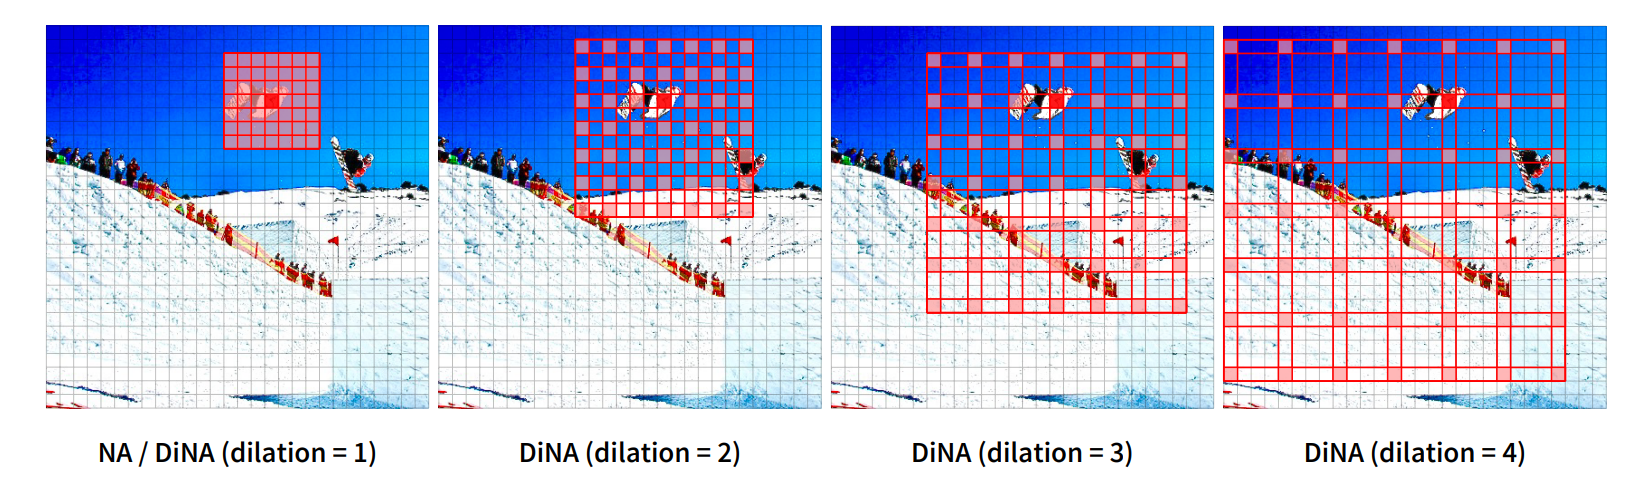

Dalam analogi sederhana, bayangkan memiliki gambar, dan setiap piksel dalam gambar tersebut perlu memahami dan fokus pada piksel-piksel di sekitarnya untuk memahami keseluruhan gambar.


In [ ]:
# Importing necessary libraries
from transformers import AutoImageProcessor, DinatForImageClassification  # Import model dan preprocessor dari transformers
from PIL import Image  # Untuk membuka gambar
import requests  # Untuk melakukan request gambar dari URL

# Mendownload gambar dari URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"  # URL gambar
image = Image.open(requests.get(url, stream=True).raw)  # Membuka gambar dari URL

# Memuat model dan preprocessor DiNAT
feature_extractor = AutoImageProcessor.from_pretrained("shi-labs/dinat-mini-in1k-224")  # Preprocessor untuk gambar
model = DinatForImageClassification.from_pretrained("shi-labs/dinat-mini-in1k-224")  # Model DiNAT yang sudah dilatih

# Menyiapkan gambar untuk model
inputs = feature_extractor(images=image, return_tensors="pt")  # Ekstraksi fitur gambar dan konversi ke format tensor

# Melakukan prediksi dengan model
outputs = model(**inputs)  # Memasukkan gambar ke model untuk mendapatkan output
logits = outputs.logits  # Mendapatkan hasil prediksi dalam bentuk logits (nilai mentah untuk setiap kelas)

# Menentukan kelas yang diprediksi berdasarkan logits
predicted_class_idx = logits.argmax(-1).item()  # Mengambil kelas dengan nilai tertinggi
print("Predicted class:", model.config.id2label[predicted_class_idx])  # Menampilkan nama kelas yang diprediksi


# Vision Transformers for Object Detection

 Bagian ini menjelaskan bagaimana tugas deteksi objek dapat dicapai menggunakan Vision Transformers (ViT). Object detection adalah tugas dalam computer vision yang melibatkan identifikasi dan pelokalan objek dalam gambar atau video. Proses ini terdiri dari dua langkah utama:
1. Mengidentifikasi jenis objek yang ada (misalnya mobil, orang, atau hewan).
2. Menentukan lokasi tepatnya dengan gambar bounding box di sekitarnya.

Model object detection biasanya menerima gambar (statis atau frame dari video) sebagai input, dengan banyak objek yang hadir dalam setiap gambar. Setelah memproses input, model ini menghasilkan serangkaian informasi yang mencakup Lokasi objek (koordinat XY dari bounding box) dan Kelas objek.

In [ ]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

In [ ]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [ ]:
# Mengakses entri pertama dari set data training
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [ ]:
# First, extract out the train and test set
# Mengakses Data Train dan Test
train_dataset = dataset["train"]
test_dataset = dataset["test"]

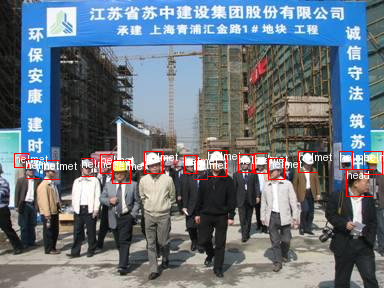

In [ ]:
import numpy as np
from PIL import Image, ImageDraw

#  digunakan untuk menggambar bounding box di atas gambar berdasarkan anotasi yang diberikan dalam dataset
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]  # Mengambil sample ke-idx dari dataset
    image = sample["image"]  # Mengambil gambar dari sample
    annotations = sample["objects"]  # Mengambil anotasi objek (bounding boxes dan kategori)
    draw = ImageDraw.Draw(image)  # Menggunakan PIL untuk menggambar pada gambar
    width, height = sample["width"], sample["height"]  # Mendapatkan ukuran gambar

    for i in range(len(annotations["id"])):  # Iterasi melalui setiap objek dalam anotasi
        box = annotations["bbox"][i]  # Mengambil bounding box untuk objek
        class_idx = annotations["id"][i]  # Mengambil ID kelas objek
        x, y, w, h = tuple(box)  # Membongkar bounding box menjadi koordinat x, y, w, h
        if max(box) > 1.0:  # Jika koordinat tidak ter-normalisasi
            x1, y1 = int(x), int(y)  # Koordinat kiri atas
            x2, y2 = int(x + w), int(y + h)  # Koordinat kanan bawah
        else:  # Jika koordinat ter-normalisasi (antara 0 dan 1)
            x1 = int(x * width)  # Menyesuaikan koordinat dengan ukuran gambar
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)  # Menggambar kotak pembatas
        draw.text((x1, y1), annotations["category"][i], fill="white")  # Menulis label kelas
    return image  # Mengembalikan gambar dengan anotasi

# untuk menggambar kotak pembatas dan label pada gambar dengan indeks ke-10 dalam dataset pelatihan
draw_image_from_idx(dataset=train_dataset, idx=10)

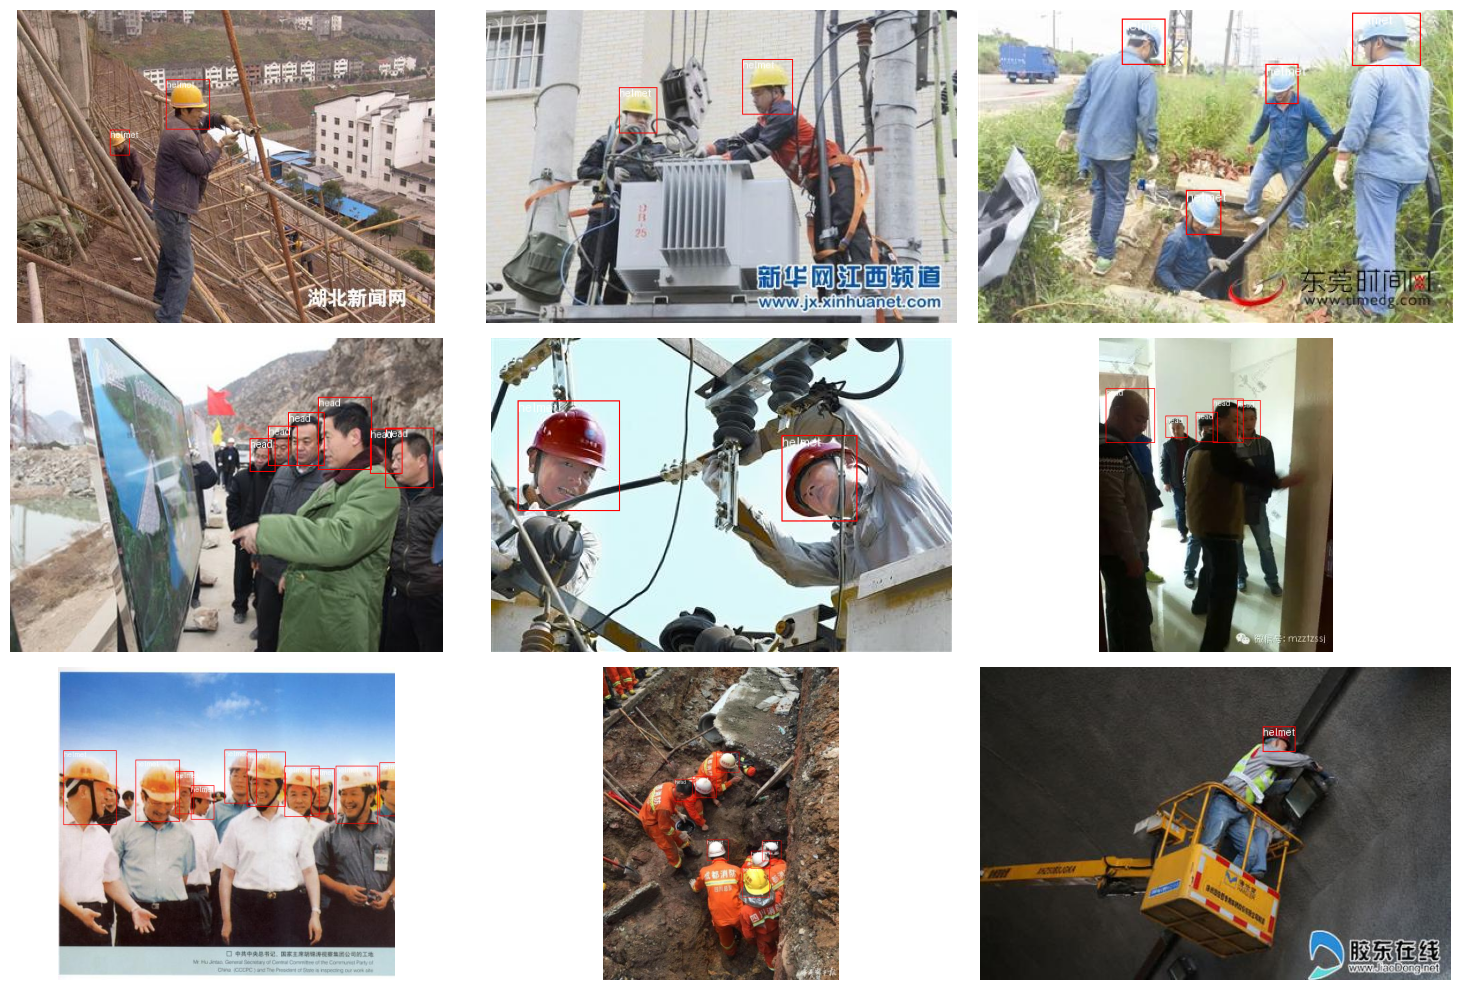

In [ ]:
import matplotlib.pyplot as plt


#digunakan untuk menampilkan beberapa gambar dari dataset dan menggambar anotasi objek pada gambar-gambar tersebut dalam bentuk grid
def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3  # Menghitung jumlah baris untuk menampilkan gambar
    num_cols = 3  # Jumlah kolom untuk menampilkan gambar
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Membuat plot

    for i, idx in enumerate(indices):
        row = i // num_cols  # Menentukan baris untuk gambar
        col = i % num_cols  # Menentukan kolom untuk gambar

        # Draw image
        image = draw_image_from_idx(dataset, idx)  # Menggambar gambar dengan anotasi

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)  # Menampilkan gambar di subplot yang sesuai
        axes[row, col].axis("off")  # Menghilangkan axis pada subplot

    plt.tight_layout()  # Menyesuaikan layout gambar
    plt.show()  # Menampilkan plot


# Now use the function to plot images
# menampilkan 9 gambar pertama dari dataset pelatihan beserta anotasi objeknya
plot_images(train_dataset, range(9))

# DEtection TRansformer (DETR)

DETR (Detection Transformer) adalah model deteksi objek berbasis Transformer yang mengubah paradigma deteksi objek tradisional. Berbeda dari metode klasik yang memanfaatkan CNN dan region proposal networks (RPN) untuk menghasilkan kandidat objek, DETR menggunakan pendekatan end-to-end yang lebih langsung dan sederhana

Arsitektur DETR:

Backbone CNN: Bagian ini bertugas mengekstraksi fitur dari gambar input. Biasanya, backbone ini adalah model CNN yang telah dilatih sebelumnya, seperti ResNet.

Positional Encoding: Setelah ekstraksi fitur, positional encoding ditambahkan untuk memberikan informasi tentang posisi relatif elemen dalam gambar, yang penting karena Transformer tidak memiliki pemahaman spasial bawaan.

Encoder-Decoder Transformer: Fitur yang telah diproses dan positional encoding kemudian diproses melalui arsitektur Transformer yang terdiri dari encoder dan decoder. Encoder menangani pemrosesan global dari fitur, sementara decoder menghasilkan prediksi objek berdasarkan fitur yang telah diproses.

Prediction Head: Decoder menghasilkan sejumlah prediksi yang mewakili objek dalam gambar, termasuk kelas objek dan koordinat bounding box.

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection  # Mengimpor class untuk pemrosesan gambar dan model DETR untuk deteksi objek
import torch  # Mengimpor PyTorch untuk operasi tensor dan model
from PIL import Image  # Mengimpor library PIL untuk memproses gambar
import requests  # Mengimpor requests untuk mengunduh gambar dari URL

url = "http://images.cocodataset.org/val2017/000000039769.jpg"  # URL gambar yang akan diuji
image = Image.open(requests.get(url, stream=True).raw)  # Mengunduh gambar dan membuka menggunakan PIL

# initialize the model
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"  # Memuat pemroses gambar untuk model DETR menggunakan pretrained weights
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"  # Memuat model DETR dengan arsitektur ResNet-101 untuk deteksi objek
)

# preprocess the inputs and infer
inputs = processor(images=image, return_tensors="pt")  # Mengubah gambar menjadi tensor untuk diproses oleh model
outputs = model(**inputs)  # Menjalankan inferensi pada model dengan input yang sudah diproses

# convert outputs (bounding boxes and class logits) to COCO API
# non max supression above 0.9
target_sizes = torch.tensor([image.size[::-1]])  # Menyiapkan ukuran target untuk gambar (reversed untuk W, H)
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9  # Memproses hasil deteksi objek dengan threshold 0.9 untuk non-max suppression
)[0]  # Mengambil hasil pertama dari list hasil deteksi

# Loop untuk menampilkan hasil deteksi objek
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]  # Membulatkan nilai koordinat bounding box ke 2 angka desimal
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"  # Menampilkan kelas yang terdeteksi, nilai confidence, dan lokasi bounding box
    )


Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50


class DETR(nn.Module):  # Mendefinisikan kelas DETR yang merupakan subclass dari nn.Module
    def __init__(
        self, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers
    ):
        super().__init__()  # Memanggil konstruktor kelas induk (nn.Module)
        self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])  # Menggunakan ResNet50 sebagai backbone, menghapus lapisan terakhir (fully connected layers dan pooling layers)
        self.conv = nn.Conv2d(2048, hidden_dim, 1)  # Menambahkan layer konvolusi untuk mengubah saluran output menjadi ukuran hidden_dim
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers
        )  # Menambahkan transformer yang digunakan untuk pemrosesan lebih lanjut
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)  # Layer linier untuk prediksi kelas (termasuk kelas latar belakang)
        self.linear_bbox = nn.Linear(hidden_dim, 4)  # Layer linier untuk prediksi bounding box (4 parameter: x, y, lebar, tinggi)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))  # Posisi query untuk transformer (dapat dipelajari)
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))  # Embedding baris untuk posisi spatial
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))  # Embedding kolom untuk posisi spatial

    def forward(self, inputs):  # Metode forward yang mendefinisikan aliran data input ke output
        x = self.backbone(inputs)  # Mendapatkan fitur dari backbone (ResNet50)
        h = self.conv(x)  # Menerapkan konvolusi untuk mengubah ukuran saluran menjadi hidden_dim
        H, W = h.shape[-2:]  # Mendapatkan dimensi height dan width dari tensor output
        pos = (
            torch.cat(
                [
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),  # Membuat embedding kolom yang diulang untuk setiap baris
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),  # Membuat embedding baris yang diulang untuk setiap kolom
                ],
                dim=-1,
            )
            .flatten(0, 1)  # Meratakan embedding posisi menjadi dimensi satu dimensi
            .unsqueeze(1)  # Menambahkan dimensi batch pada posisi
        )
        h = self.transformer(
            pos + h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)  # Menerapkan transformer pada data yang telah diratakan dengan posisi dan query
        )
        return self.linear_class(h), self.linear_bbox(h).sigmoid()  # Mengembalikan hasil prediksi kelas dan bounding box, sigmoid digunakan untuk normalisasi bounding box


# Transformer-based image segmentation

Pada bagian ini, perbandingan antara Convolutional Neural Networks dan Vision Transformers  dalam konteks segmentasi gambar dijelaskan secara rinci.

Perbandingan CNN dan Transformer untuk Segmentasi:

Sebelum munculnya Vision Transformers, CNNs seperti U-Net dan Mask R-CNN telah menjadi pilihan utama untuk segmentasi gambar. Meskipun berhasil, model berbasis CNN memiliki beberapa keterbatasan yang coba diatasi oleh Transformer:

Keterbatasan Receptive Field: CNNs memiliki receptive field terbatas, yang dapat membatasi kemampuan mereka dalam menangkap konteks global dalam gambar.

Kesulitan dalam Menangani Variasi Skala dan Orientasi: CNNs mungkin kesulitan dalam menangani objek dengan variasi skala dan orientasi yang signifikan.

Arsitektur Transformer untuk Segmentasi

Sementara itu, Vision Transformers (ViTs) memanfaatkan kekuatan mekanisme self-attention untuk memproses gambar secara global. Dalam arsitektur segmentasi berbasis ViT, umumnya digunakan struktur encoder-decoder:

Encoder: Menggunakan Vision Transformer untuk menangkap representasi global dari gambar.

Decoder: Menggunakan mekanisme self-attention untuk memproses informasi dan menghasilkan peta segmentasi akhir.


Keuntungan Menggunakan Vision Transformer untuk Segmentasi:

Konteks Global: Kemampuan untuk menangkap konteks global dalam gambar, yang penting untuk segmentasi yang akurat.

Fleksibilitas: Kemampuan untuk menangani variasi skala dan orientasi objek dengan lebih baik.

In [ ]:
from transformers import pipeline  # Mengimpor class pipeline dari transformers untuk memudahkan pemrosesan tugas AI
from PIL import Image  # Mengimpor library PIL untuk memproses gambar
import requests  # Mengimpor library requests untuk mengunduh gambar dari URL

# Memuat pipeline untuk segmentasi gambar menggunakan model 'facebook/maskformer-swin-base-coco'
segmentation = pipeline("image-segmentation", "facebook/maskformer-swin-base-coco")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"  # URL gambar yang akan diuji
image = Image.open(requests.get(url, stream=True).raw)  # Mengunduh gambar dari URL dan membuka gambar menggunakan PIL

# Menjalankan segmentasi pada gambar yang diunduh dengan subtask 'panoptic' untuk menghasilkan segmentasi panoptic
results = segmentation(images=image, subtask="panoptic")
results  # Menampilkan hasil segmentasi gambar


Device set to use cuda:0
`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.993197,
  'label': 'remote',
  'mask': <PIL.Image.Image image mode=L size=640x480>},
 {'score': 0.997852,
  'label': 'cat',
  'mask': <PIL.Image.Image image mode=L size=640x480>},
 {'score': 0.998006,
  'label': 'remote',
  'mask': <PIL.Image.Image image mode=L size=640x480>},
 {'score': 0.997469,
  'label': 'cat',
  'mask': <PIL.Image.Image image mode=L size=640x480>}]

#  OneFormer

OneFormer adalah kerangka kerja segmentasi gambar universal yang menggabungkan berbagai jenis segmentasi semantik, instance, dan panoptic dalam satu model transformer tunggal. Berbeda dengan pendekatan sebelumnya yang memerlukan pelatihan terpisah untuk setiap jenis segmentasi, OneFormer memungkinkan pelatihan multi-tugas dalam satu proses, sehingga meningkatkan efisiensi dan kinerja

In [ ]:
!pip install -q natten

In [ ]:
# Import library yang dibutuhkan untuk pemrosesan dan segmentasi gambar
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Fungsi untuk menjalankan segmentasi gambar berdasarkan tipe tugas yang diberikan
def run_segmentation(image, task_type):
    """Performs image segmentation based on the given task type.

    Args:
        image (PIL.Image): The input image.
        task_type (str): The type of segmentation to perform ('semantic', 'instance', or 'panoptic').

    Returns:
        PIL.Image: The segmented image.

    Raises:
        ValueError: If the task type is invalid.
    """

    # Memuat processor dan model OneFormer dari Hugging Face
    processor = OneFormerProcessor.from_pretrained(
        "shi-labs/oneformer_ade20k_dinat_large"
    )  # Load once here
    model = OneFormerForUniversalSegmentation.from_pretrained(
        "shi-labs/oneformer_ade20k_dinat_large"
    )

    # Proses segmentasi untuk berbagai tipe (semantic, instance, atau panoptic)
    if task_type == "semantic":
        # Mengolah input untuk segmentasi semantik
        inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
        outputs = model(**inputs)
        predicted_map = processor.post_process_semantic_segmentation(
            outputs, target_sizes=[image.size[::-1]]
        )[0]

    elif task_type == "instance":
        # Mengolah input untuk segmentasi instance
        inputs = processor(images=image, task_inputs=["instance"], return_tensors="pt")
        outputs = model(**inputs)
        predicted_map = processor.post_process_instance_segmentation(
            outputs, target_sizes=[image.size[::-1]]
        )[0]["segmentation"]

    elif task_type == "panoptic":
        # Mengolah input untuk segmentasi panoptic
        inputs = processor(images=image, task_inputs=["panoptic"], return_tensors="pt")
        outputs = model(**inputs)
        predicted_map = processor.post_process_panoptic_segmentation(
            outputs, target_sizes=[image.size[::-1]]
        )[0]["segmentation"]

    else:
        # Menangani jika tipe tugas tidak valid
        raise ValueError(
            "Invalid task type. Choose from 'semantic', 'instance', or 'panoptic'"
        )

    # Mengembalikan peta segmentasi hasil prediksi
    return predicted_map


# Fungsi untuk menampilkan gambar asli dan hasil segmentasi secara berdampingan
def show_image_comparison(image, predicted_map, segmentation_title):
    """Displays the original image and the segmented image side-by-side.

    Args:
        image (PIL.Image): The original image.
        predicted_map (PIL.Image): The segmented image.
        segmentation_title (str): The title for the segmented image.
    """

    # Menggambar kedua gambar (gambar asli dan hasil segmentasi) dalam satu plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_map)
    plt.title(segmentation_title + " Segmentation")
    plt.axis("off")
    plt.show()


# Mengambil gambar dari URL
url = "https://huggingface.co/datasets/shi-labs/oneformer_demo/resolve/main/ade20k.jpeg"
response = requests.get(url, stream=True)
response.raise_for_status()  # Memastikan tidak ada kesalahan HTTP
image = Image.open(response.raw)

# Menentukan tipe segmentasi yang akan dijalankan
task_to_run = "semantic"
# Melakukan segmentasi dan mendapatkan peta segmentasi
predicted_map = run_segmentation(image, task_to_run)
# Menampilkan perbandingan antara gambar asli dan gambar hasil segmentasi
show_image_comparison(image, predicted_map, task_to_run)


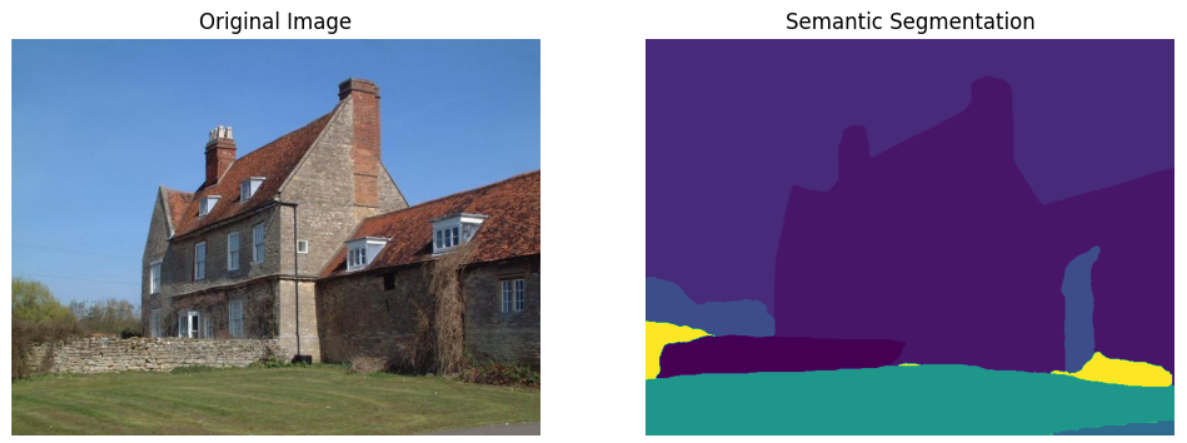